<a href="https://colab.research.google.com/github/oskrplopez81/DCDP_2022/blob/main/Reduccion_dimensiones_encod_decod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
 #trabajar con arrays y dataframes
import numpy as np
import pandas as pd
# crear mis capas densas
from keras.models import Model
from keras.layers import Input, Dense
#monitorear que no existe sobreajuste , es decir que mi modelo generalize bien.
from keras.callbacks import EarlyStopping
# Optimizador para ajustar pesos de mi red neuronal con el objetivo de minimizar la función de pérdida.
from keras.optimizers import Adam
#Evitar sobreajuste, apaga un % de neuronas
from keras.layers import Dropout
#Escalador, modelo ML ,split y matriz de confusion
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Diplomado Bourbaki DL2/reto1.csv")

In [ ]:
df.head(3)

,ID,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
0,130,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,1299,649.5,1299,0,1
1,195,0,0,0,0,0,0,0,0,0,...,0,0,0,3,3,4119,1373.0,2470,0,1
2,217,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2806,1403.0,2799,7,1


In [ ]:
df_f=df.copy()
df_fX=df_f.drop(columns=['ID', 'fraud_flag'])
df_fY=df_f['fraud_flag']

In [ ]:
df_fX.shape

(9319, 2455)

In [ ]:
df_fX = df_fX.astype(float)

#scaler = StandardScaler() # datos normalizados
scaler = MinMaxScaler() # datos entre 0 a 1
df_fX_scaled = scaler.fit_transform(df_fX)

In [ ]:
print(type(df_fX_scaled))
print(len(df_fX_scaled[1]))
print(df_fX_scaled.shape)

<class 'numpy.ndarray'>
2455
(9319, 2455)


## ¿Por que uso Sigmoide y no Relu en decoder_output?
Por que las variables las tengo entre 0 y 1, y Relu permite valores de [0,inf), y podemos caer en un rango fuera del 1,
Sigmoide va de 0 a 1, esto permite que mi modelo generalize correctamente.

In [ ]:
input_dim = df_fX_scaled.shape[1]
encoding_dim = 25

#Capa de entrada
input_layer = Input(shape=(input_dim,))
# Codificador: Reduce la dimensionalidad
encoder = Dense(1024, activation="relu")(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(512, activation="relu")(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(256, activation="relu")(encoder)
encoder_output = Dense(encoding_dim, activation="relu")(encoder)

# Decodificador: Reconstruye los datos originales
decoder = Dense(256, activation="relu")(encoder_output)
decoder = Dropout(0.2)(decoder)
decoder = Dense(512, activation="relu")(decoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(1024, activation="relu")(decoder)
#modificar a Relu en el decoder_output
decoder_output = Dense(input_dim, activation="sigmoid")(decoder)
#decoder_output = Dense(input_dim, activation="relu")(decoder)

# Modelo de Autoencoder completo
autoencoder = Model(inputs=input_layer, outputs=decoder_output)

#tasa de aprendizaje
optimizer = Adam(learning_rate=0.00001)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
#autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(df_fX_scaled, df_fX_scaled,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stopping])

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 419ms/step - loss: 0.2498 - val_loss: 0.2496
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - loss: 0.2495 - val_loss: 0.2491
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - loss: 0.2487 - val_loss: 0.2462
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - loss: 0.2433 - val_loss: 0.2262
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - loss: 0.2101 - val_loss: 0.1344
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.1011 - val_loss: 0.0254
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - loss: 0.0177 - val_loss: 0.0053
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - loss: 0.0012 - val_loss: 9.0675e-04


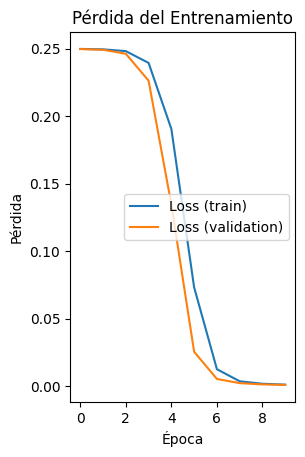

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Pérdida del Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
#arquitectura del modelo
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2455)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,514,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 25)                  │           6,425 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2455)                │       2,516,375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,072,274 (72.75 MB)

 Trainable params: 6,357,424 (24.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,714,850 (48.50 MB)

In [ ]:
# Modelo codificador
encoder_model = Model(inputs=input_layer, outputs=encoder_output)

# Obtener la representación comprimida de los datos
df_fX_compressed = encoder_model.predict(df_fX_scaled)

# df_fX_compressed ahora tiene la dimensionalidad reducida (9319, 25)
print(df_fX_compressed.shape)

292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
(9319, 25)


In [ ]:
print(df_fX_scaled.shape)
print(encoder_output.shape)
print(df_fY.shape)
print(df_fX_compressed.shape)

(9319, 2455)
(None, 25)
(9319,)
(9319, 25)


## **Regresión Logistica**

In [ ]:
# Split entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_fX_compressed, df_fY, test_size=0.2, random_state=42)

In [ ]:
# Instancia del modelo
model = LogisticRegression()

# Entrena el modelo
model.fit(X_train, y_train)

# predicciones
y_pred = model.predict(X_test)

#metricas de rendimiento de logistica
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1597
           1       0.00      0.00      0.00       267

    accuracy                           0.86      1864
   macro avg       0.43      0.50      0.46      1864
weighted avg       0.73      0.86      0.79      1864



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


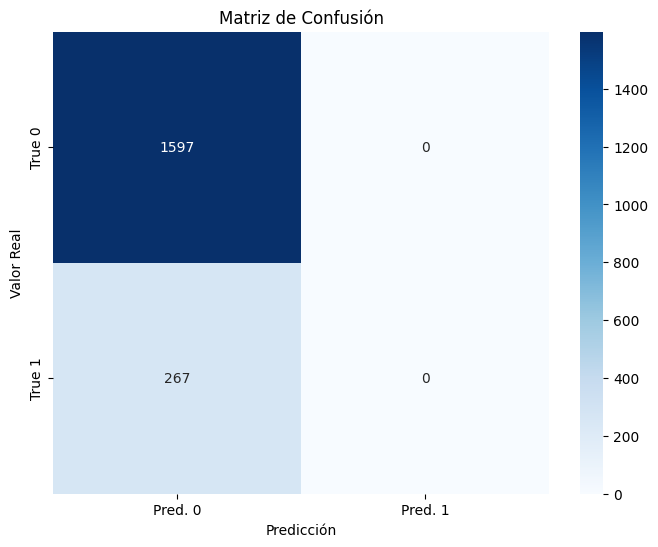

In [ ]:
import seaborn as sns
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar matriz de conf
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred. 0', 'Pred. 1'], yticklabels=['True 0', 'True 1'])

plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

Ahora hago un sobremuestreo para balancear mis datos para las etiqueta menos frecuente

In [ ]:
# Instancia de SMOTE
smote = SMOTE(random_state=42)

# Instancia el modelo de regresión logística
model2 = LogisticRegression()

# Ajustar los datos
X_res, y_res = smote.fit_resample(X_train, y_train)

# Entrena el modelo
model2.fit(X_res, y_res)

# predicciones
y_pred2 = model2.predict(X_test)

# Métricas de rendimiento
print(classification_report(y_test, y_pred2))


              precision    recall  f1-score   support

           0       0.89      0.41      0.56      1597
           1       0.17      0.70      0.27       267

    accuracy                           0.45      1864
   macro avg       0.53      0.55      0.41      1864
weighted avg       0.79      0.45      0.52      1864



In [ ]:
# probas
probabilidades = model2.predict_proba(X_test)

# clases
etiquetas = model2.classes_

print("Etiquetas de las clases:", etiquetas[0])
print("Probabilidades de predicción:", probabilidades[0])

Etiquetas de las clases: 0
Probabilidades de predicción: [0.48399175 0.51600825]


In [ ]:
y_test.iloc[30]

0

In [ ]:
probabilidades[3]

array([0.47846763, 0.52153237])

In [ ]:
y_test.iloc[i]

1

In [ ]:
'''
for i, prob in enumerate(probabilidades):
    # etiqueta real
    etiqueta_real = y_test.iloc[i]

    print(f"Instancia {i}:")
    print(f"  Etiqueta real: {etiqueta_real}")

    # probas para cada clase
    for j, etiqueta in enumerate(etiquetas):
        print(f"  Clase {etiqueta}: {prob[j]}")
'''


'\nfor i, prob in enumerate(probabilidades):\n    # etiqueta real \n    etiqueta_real = y_test.iloc[i]\n    \n    print(f"Instancia {i}:")\n    print(f"  Etiqueta real: {etiqueta_real}")\n    \n    # probas para cada clase\n    for j, etiqueta in enumerate(etiquetas):\n        print(f"  Clase {etiqueta}: {prob[j]}")\n'

In [ ]:
y_prob2 = model2.predict_proba(X_test)[:, 1]

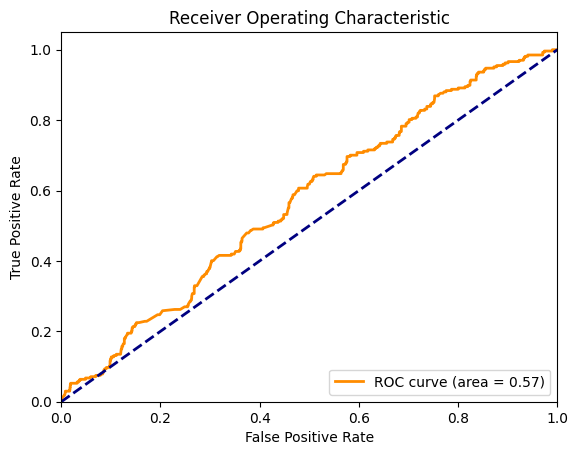

In [ ]:
# Calcular la curva ROC
fpr2, tpr2, thresholds = roc_curve(y_test, y_prob2)

# Calcular el AUC
roc_auc = auc(fpr2, tpr2)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

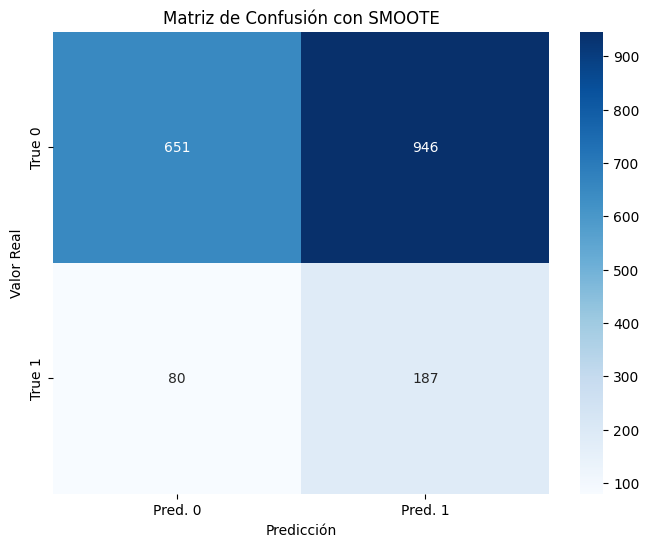

In [ ]:
# Matriz de confusión
conf_matrix2 = confusion_matrix(y_test, y_pred2)

# Graficar matriz de conf
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred. 0', 'Pred. 1'], yticklabels=['True 0', 'True 1'])

plt.title("Matriz de Confusión con SMOOTE")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

In [ ]:
# Obtener las probabilidades para la clase 1
probabilidades_clase_1 = model2.predict_proba(X_test)[:, 1]

# Ajustar el umbral de decisión (por ejemplo, 0.3 en lugar de 0.5)
umbral = 0.4
y_pred_ajustado = (probabilidades_clase_1 >= umbral).astype(int)

# Evaluar el rendimiento del modelo con el nuevo umbral
print(classification_report(y_test, y_pred_ajustado))


              precision    recall  f1-score   support

           0       0.90      0.04      0.07      1597
           1       0.14      0.98      0.25       267

    accuracy                           0.17      1864
   macro avg       0.52      0.51      0.16      1864
weighted avg       0.80      0.17      0.09      1864



Área bajo la curva (AUC): 0.61


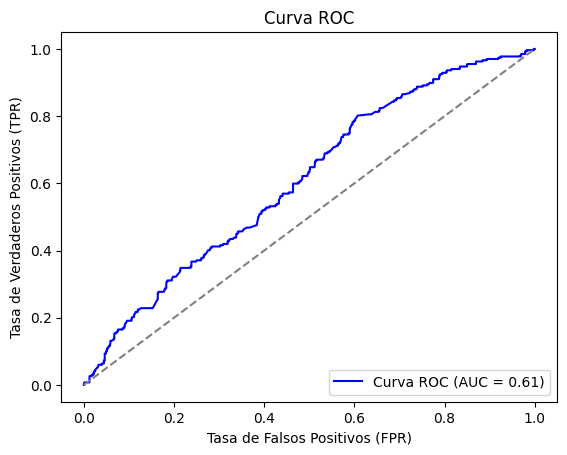

In [ ]:
# Calcular la curva ROC y el AUC
fpr2, tpr2, umbrales = roc_curve(y_test, probabilidades_clase_1)
roc_auc2 = auc(fpr2, tpr2)

# Imprimir el AUC
print(f"Área bajo la curva (AUC): {roc_auc2:.2f}")

# Graficar la curva ROC
plt.figure()
plt.plot(fpr2, tpr2, color='blue', label=f'Curva ROC (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Best parameters: {'C': 100, 'class_weight': {0: 1, 1: 5}}


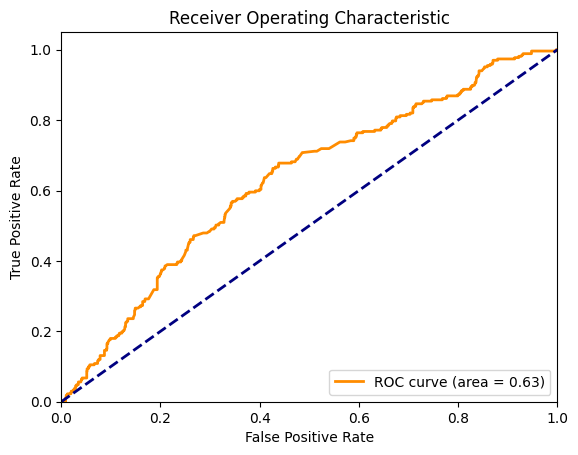

Best AUC: 0.63


In [ ]:
# Definir el rango de hiperparámetros a probar
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
    'class_weight': [{0: 1, 1: 6},{0: 1, 1: 5},{0: 1, 1: 7}, {0: 1, 1: 10}, 'balanced']
}

# Instancia del modelo de regresión logística
model3 = LogisticRegression()

# Instancia de GridSearchCV
grid_search = GridSearchCV(model3, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Mejor hiperparámetro
print(f'Best parameters: {grid_search.best_params_}')

# Evaluar el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el AUC para el mejor modelo
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'Best AUC: {roc_auc_best:.2f}')
